In [112]:
# Imported Libraries
#!pip install pandas-datareader
import pandas as pd
import numpy as np
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data, wb
import datetime
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tsa.arima.model import ARIMA
import six
import sys
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from pmdarima.arima import auto_arima
# from pmdarima.arima import ARIMA as ARMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [113]:
# Gathering Data
ABT = data.DataReader('ABT', 'yahoo', datetime.datetime(2004, 1, 1), datetime.date.today())

In [114]:
# Run once
ABT.reset_index(inplace=True) 

In [115]:
ABT

,Date,High,Low,Open,Close,Volume,Adj Close
0,2004-01-02,21.165676,20.802067,20.918781,20.986116,6894172.0,13.728784
1,2004-01-05,21.210567,20.739222,21.143230,20.986116,14395828.0,13.728784
2,2004-01-06,20.959183,20.721266,20.851446,20.833490,7790584.0,13.628943
3,2004-01-07,21.053452,20.716776,20.851446,21.053452,7774322.0,13.772837
4,2004-01-08,20.447435,20.249920,20.424990,20.433968,17053876.0,13.367580
...,...,...,...,...,...,...,...
4372,2021-05-17,118.349998,116.669998,118.000000,116.739998,3732400.0,116.739998
4373,2021-05-18,118.000000,116.720001,116.720001,116.980003,3398400.0,116.980003
4374,2021-05-19,116.430000,115.160004,116.160004,116.379997,3430800.0,116.379997
4375,2021-05-20,117.970001,116.410004,116.550003,117.800003,2858200.0,117.800003


In [116]:
# Set tome period for futue forecast
forecast_dates = [i.date() for i in list(pd.date_range(start = datetime.date.today(), 
                                                       end = "2021-12-31"))[1:] 
                  if i.weekday() in [0, 1, 2, 3, 4]]

In [117]:
# Function to calculate MAPE
def MAPE(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## Forecast based on end of year

"""
# filter out for each year's ending adjusted price
end_year_unstationary = ABT.groupby(ABT.Date.dt.year).last()['Adj Close']
end_year = ABT.groupby(ABT.Date.dt.year).last()['Adj Close']


# Making data stationary
end_year_unstationary['log'] = np.log(end_year_unstationary)
end_year_unstationary['log diff'] = end_year_unstationary['log'] - end_year_unstationary['log'].shift(1)
end_year_unstationary['log diff'].dropna().plot()
"""

In [118]:
end_year = ABT.groupby(ABT.Date.dt.year).last()['Adj Close']

In [119]:
# end_year = end_year_unstationary['log diff'].dropna()
end_year.to_csv('yearly_data.csv')

In [120]:
end_year

Date
2004     15.007044
2005     12.983624
2006     16.471537
2007     19.443533
2008     18.960272
2009     19.828472
2010     18.188885
2011     22.149736
2012     26.645042
2013     33.028294
2014     39.661587
2015     40.403961
2016     35.425930
2017     53.857410
2018     69.509361
2019     84.857170
2020    108.651741
2021    117.129997
Name: Adj Close, dtype: float64

In [121]:
def Yearly(p,d,q):
    # End of the Year ARIMA Model
    # This model takes all the ending stock prices and forecasts for 2021 end of the year
    testing_model = ARIMA(list(end_year[:-4].values), order = (p,d,q)).fit()
    testing_forecasts = list(testing_model.forecast(steps = 3))
    print('Forecasts (2018-2020):\t', [round(x,2) for x in testing_forecasts])
    print('Actual (2018-2020):\t', [round(x,2) for x in list(end_year[-4:-1].values)])
    print('MAPE:\t\t\t {}'.format(MAPE(list(end_year[-4:-1].values), testing_forecasts)))

    # Forecasting End of Year Value for 2021
    model1 = ARIMA(list(end_year.values), order = (p,d,q)).fit()
    forecasts1 = list(model1.forecast(steps = 1))
    forecasts1 = forecasts1[-1]
    print('\nEnd of Year Forecast for 2021: ${}'.format(forecasts1))  
    
    # Checking Yearly Forecast
    to_graph = ABT.groupby(ABT.Date.dt.year).last()[['Date', 'Adj Close']]
    to_graph.loc[2021,'Adj Close'] = forecasts1
    plt.figure(figsize = (15,5))
    plt.plot(to_graph['Date'][:-1], to_graph['Adj Close'][:-1], color = 'red')
    plt.plot(to_graph['Date'][-2:], to_graph['Adj Close'][-2:], color = 'blue')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

In [143]:
auto_arima(end_year, end_year.index.to_numpy().reshape((-1, 1)), trace=True, seasonal=False).order

Fit ARIMA: order=(2, 0, 2); AIC=129.729, BIC=135.961, Fit time=1.793 seconds
Fit ARIMA: order=(0, 0, 0); AIC=154.020, BIC=156.691, Fit time=0.035 seconds
Fit ARIMA: order=(1, 0, 0); AIC=133.263, BIC=136.825, Fit time=1.086 seconds
Fit ARIMA: order=(0, 0, 1); AIC=140.050, BIC=143.612, Fit time=0.334 seconds
Fit ARIMA: order=(1, 0, 2); AIC=227.260, BIC=232.602, Fit time=3.875 seconds
Fit ARIMA: order=(3, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=130.470, BIC=134.922, Fit time=2.548 seconds
Fit ARIMA: order=(3, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 10.833 seconds


(2, 0, 2)

Forecasts (2018-2020):	 [57.72, 58.03, 70.36]
Actual (2018-2020):	 [69.51, 84.86, 108.65]
MAPE:			 27.936995942966096

End of Year Forecast for 2021: $130.27155918153682


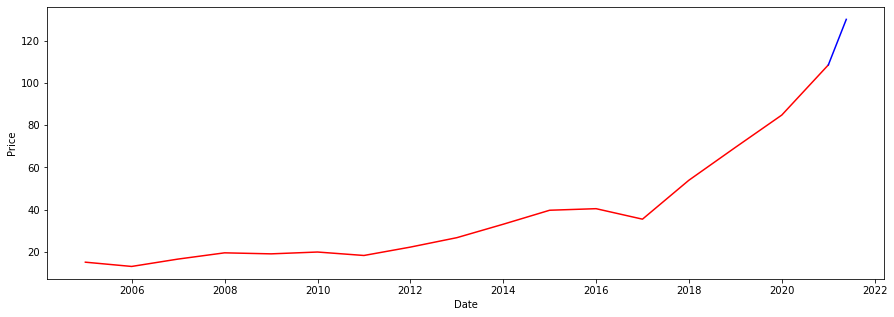

LinAlgError: LU decomposition error.

In [144]:
Yearly(2,2,0)
Yearly(5,4,1)

## Forecast based on end of month

In [145]:
ABT['Month'] = ABT.Date.dt.month
end_month = pd.DataFrame(ABT[ABT.Date.dt.year == 2004].groupby('Month').last())
for year in sorted(set(ABT.Date.dt.year))[1:]:
    end_month = end_month.append(pd.DataFrame(ABT[ABT.Date.dt.year == year].groupby('Month').last()), sort=False)
end_month = end_month.reset_index(drop = True)
end_month = end_month[['Date','Adj Close']]

end_month.to_csv('monthly_data.csv')


In [160]:
def Monthly(p,d,q):
    testing_model = ARIMA(list(end_month['Adj Close'].values[:-4]), order = (p,d,q)).fit() # 5,9,1 #6,0,1 #6,1,1 #6,2,9 #6,1,9 #2,1,9 #5,1,9
    testing_forecasts = list(testing_model.forecast(steps = 3))
    
    print("order = ", p,",", d,",", q)
    print('Forecasts (Dec 2020 - Feb 2021):\t', [round(x,2) for x in testing_forecasts])
    print('Actual (Dec 2020 - Feb 2021):\t\t', [round(x,2) for x in end_month['Adj Close'].values[-4:-1]])

    MSE_error = mean_absolute_error(end_month['Adj Close'].values[-4:-1], testing_forecasts)
    print('MAPE:\t\t\t\t\t {}'.format(MAPE(list(end_month['Adj Close'].values[-4:-1]), testing_forecasts)))

    # Forecasting End of Month Value for Dec 2021
    forecasts2 = list(testing_model.forecast(steps = 13))
    print('\nEnd of Month Forecast for Dec 2021: ${}'.format(forecasts2[-1]))
    
    
    forecast_dates = [i.date() for i in list(pd.date_range(start = "2020-12-31", 
                                                       end = "2021-12-31"))[1:] 
                  if i.weekday() in [0, 1, 2, 3, 4]]
    i = pd.DataFrame(forecast_dates)
    i['Month'] = [x.month for x in list(i[0])]
    i = i.groupby('Month').last().reset_index(drop = True)
    i['Adj Close'] = forecasts2[1:]

    # Checking Monthly Forecast 
    plt.figure(figsize=(18,5))
    plt.plot(end_month["Date"], end_month["Adj Close"], color = 'red')
    plt.plot(i[0], i['Adj Close'], color = 'blue') # Monthly ARIMA
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()
    
    

In [154]:
#print(auto_arima(end_month['Adj Close'].values[:-4]))
order = auto_arima(end_month['Adj Close'].values, end_month.index.to_numpy().reshape((-1, 1)), trace=True, seasonal=False).order
order

Fit ARIMA: order=(2, 1, 2); AIC=941.574, BIC=964.937, Fit time=2.205 seconds
Fit ARIMA: order=(0, 1, 0); AIC=965.919, BIC=975.932, Fit time=0.076 seconds
Fit ARIMA: order=(1, 1, 0); AIC=965.679, BIC=979.029, Fit time=0.398 seconds
Fit ARIMA: order=(0, 1, 1); AIC=963.558, BIC=976.908, Fit time=0.193 seconds
Fit ARIMA: order=(1, 1, 2); AIC=959.055, BIC=979.080, Fit time=0.922 seconds
Fit ARIMA: order=(3, 1, 2); AIC=943.176, BIC=969.877, Fit time=2.934 seconds
Fit ARIMA: order=(2, 1, 1); AIC=955.924, BIC=975.949, Fit time=0.597 seconds
Fit ARIMA: order=(2, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1); AIC=960.838, BIC=977.526, Fit time=0.652 seconds
Fit ARIMA: order=(3, 1, 3); AIC=944.388, BIC=974.426, Fit time=7.279 seconds
Total fit time: 15.367 seconds


(2, 1, 2)

order =  2 , 1 , 2
Forecasts (Dec 2020 - Feb 2021):	 [122.07, 119.17, 118.77]
Actual (Dec 2020 - Feb 2021):		 [119.34, 119.4, 120.08]
MAPE:					 1.188912171102089

End of Month Forecast for Dec 2021: $119.94644742613582


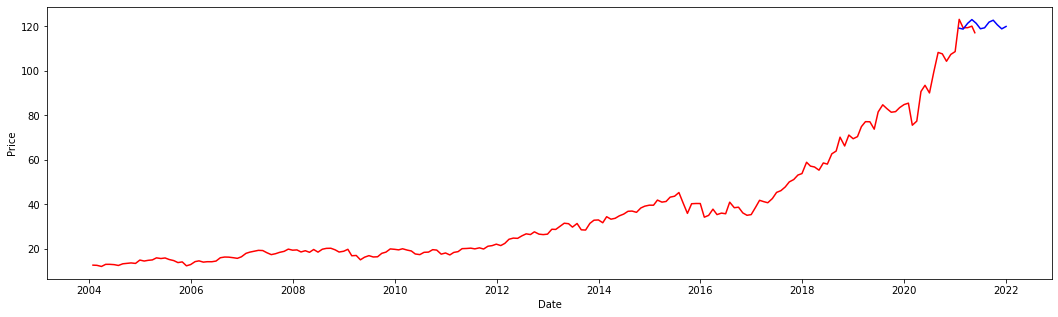



order =  0 , 2 , 2
Forecasts (Dec 2020 - Feb 2021):	 [122.74, 124.94, 127.14]
Actual (Dec 2020 - Feb 2021):		 [119.34, 119.4, 120.08]
MAPE:					 4.452666946039232

End of Month Forecast for Dec 2021: $149.1319286577089


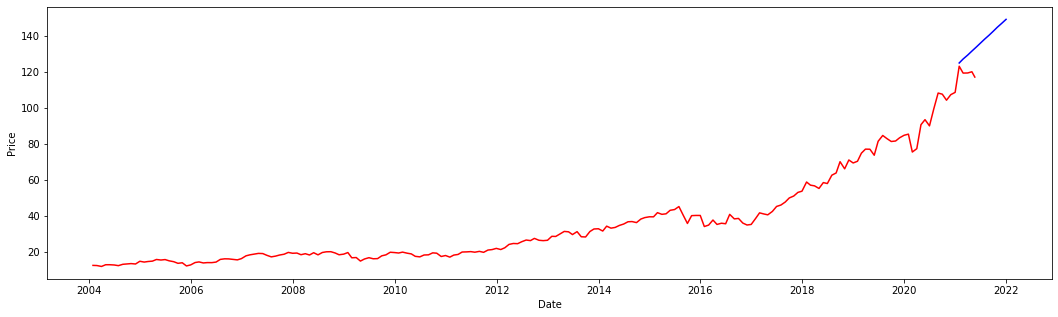



order =  1 , 2 , 1
Forecasts (Dec 2020 - Feb 2021):	 [124.23, 126.36, 128.41]
Actual (Dec 2020 - Feb 2021):		 [119.34, 119.4, 120.08]
MAPE:					 5.622010326507689

End of Month Forecast for Dec 2021: $148.96820271589883


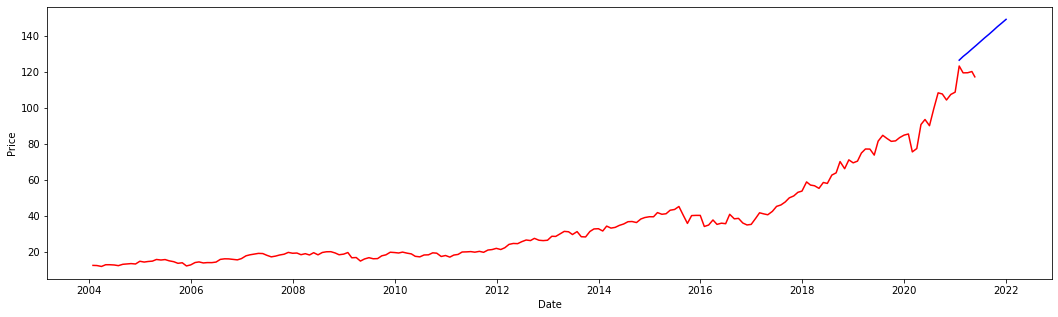



order =  6 , 0 , 1
Forecasts (Dec 2020 - Feb 2021):	 [121.98, 121.8, 122.16]
Actual (Dec 2020 - Feb 2021):		 [119.34, 119.4, 120.08]
MAPE:					 1.9816570990506404

End of Month Forecast for Dec 2021: $127.50608788693184


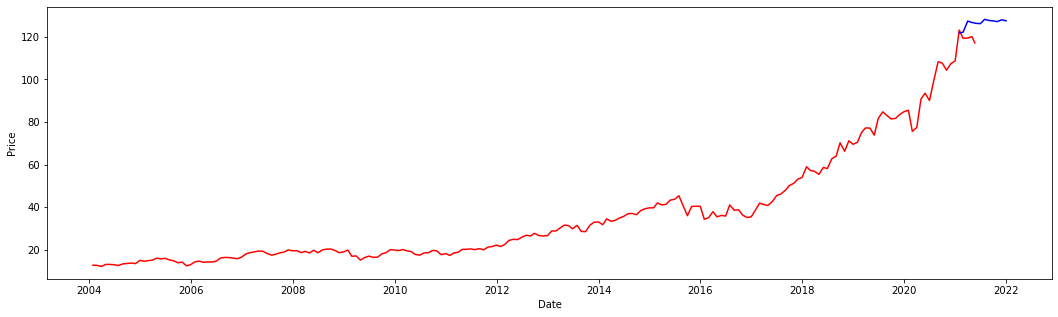



order =  6 , 1 , 1
Forecasts (Dec 2020 - Feb 2021):	 [122.53, 122.31, 123.27]
Actual (Dec 2020 - Feb 2021):		 [119.34, 119.4, 120.08]
MAPE:					 2.591017666215455

End of Month Forecast for Dec 2021: $147.85957260711896


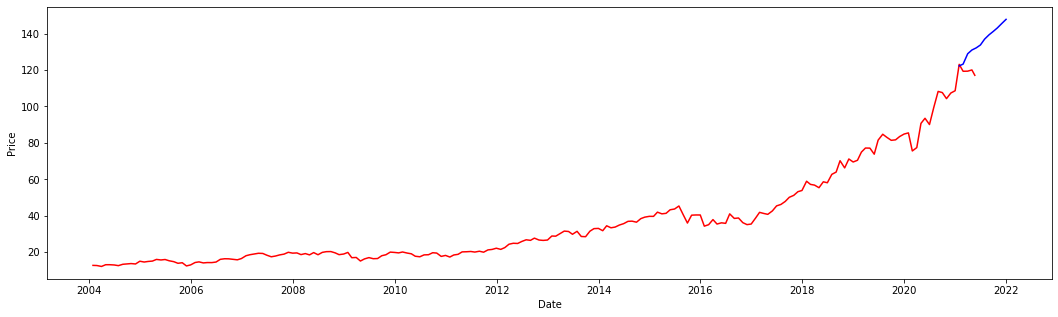



order =  6 , 2 , 9
Forecasts (Dec 2020 - Feb 2021):	 [128.75, 123.41, 120.97]
Actual (Dec 2020 - Feb 2021):		 [119.34, 119.4, 120.08]
MAPE:					 3.993356370657713

End of Month Forecast for Dec 2021: $150.88451599137096


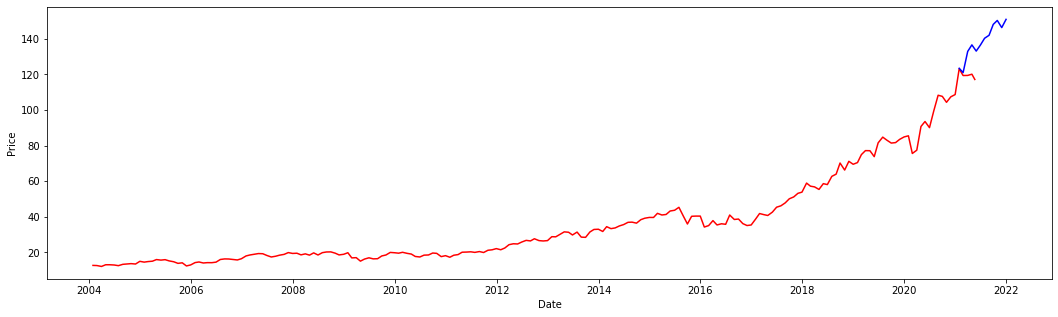



order =  6 , 1 , 9
Forecasts (Dec 2020 - Feb 2021):	 [127.79, 123.37, 122.0]
Actual (Dec 2020 - Feb 2021):		 [119.34, 119.4, 120.08]
MAPE:					 4.0007365432482676

End of Month Forecast for Dec 2021: $152.17807496495223


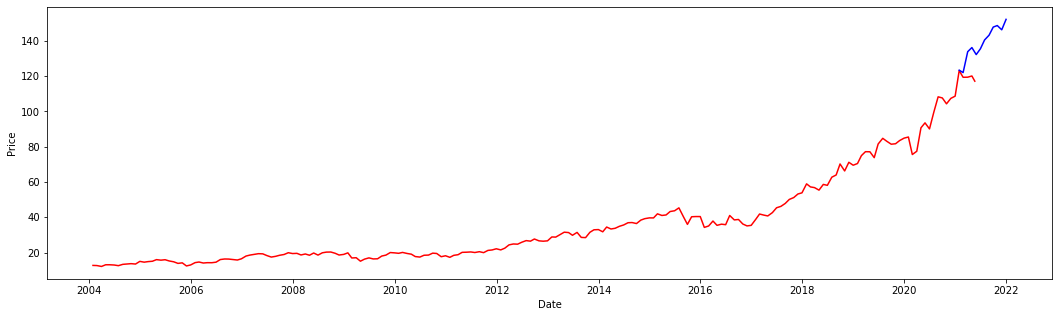



order =  2 , 1 , 9
Forecasts (Dec 2020 - Feb 2021):	 [126.04, 122.88, 120.8]
Actual (Dec 2020 - Feb 2021):		 [119.34, 119.4, 120.08]
MAPE:					 3.0403702590544284

End of Month Forecast for Dec 2021: $128.93476815329802


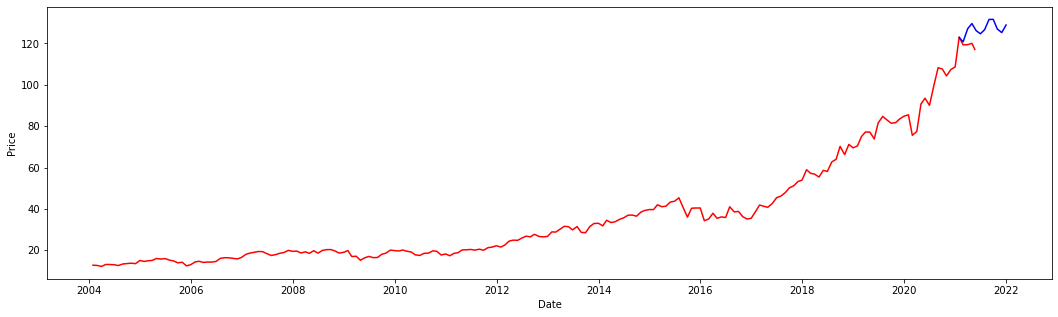



order =  5 , 1 , 9
Forecasts (Dec 2020 - Feb 2021):	 [127.93, 123.36, 121.98]
Actual (Dec 2020 - Feb 2021):		 [119.34, 119.4, 120.08]
MAPE:					 4.0320293635379585

End of Month Forecast for Dec 2021: $152.48200327488354


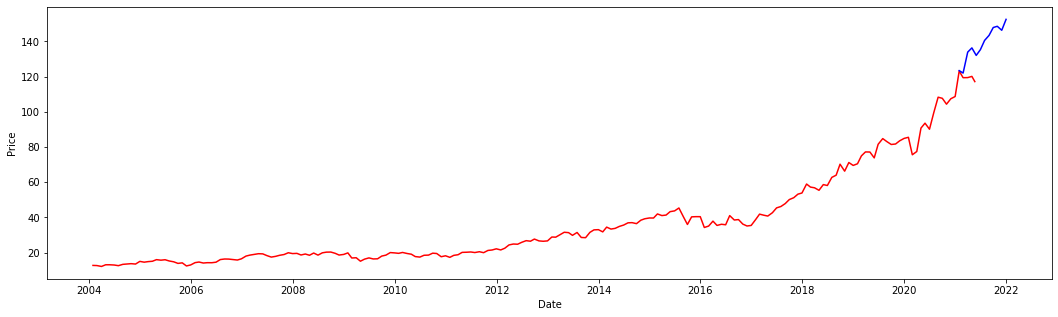

In [161]:
# Auto ARIMA
Monthly(2,1,2)
print("\n")

# All others
Monthly(0,2,2)
print("\n")
Monthly(1,2,1)
print("\n")
Monthly(6,0,1) #used
print("\n")
Monthly(6,1,1)
print("\n")
Monthly(6,2,9)
print("\n")
Monthly(6,1,9)
print("\n")
Monthly(2,1,9)
print("\n")
Monthly(5,1,9)


## Forecast based on end of quarter

In [162]:
Quarters = []
for m in ABT.Month:
    if m in [1, 2, 3]:
        Quarters.append('Quarter 1')
    elif m in [4, 5, 6]:
        Quarters.append('Quarter 2')
    elif m in [7, 8, 9]:
        Quarters.append('Quarter 3')
    elif m in [10, 11, 12]:
        Quarters.append('Quarter 4')
ABT['Quarter'] = Quarters
ABT['Year'] = ABT.Date.dt.year

In [163]:
quarter = ABT.groupby(['Year', 'Quarter']).last()
quarter.to_csv('quarterly_data.csv')

In [164]:
def Quarterly(p,d,q):
    testing_model = ARIMA(list(quarter['Adj Close'].values[:-4]), order = (p,d,q)).fit() #8,2,10
    testing_forecasts = list(testing_model.forecast(steps = 3))
    print('Forecasts (Dec 2020 - Feb 2021):\t', [round(x,2) for x in testing_forecasts])
    print('Actual (Dec 2020 - Feb 2021):\t\t', [round(x,2) for x in end_month['Adj Close'].values[-4:-1]])

    MSE_error = mean_absolute_error(end_month['Adj Close'].values[-4:-1], testing_forecasts)
    print('MAPE:\t\t\t\t\t {}'.format(MAPE(list(end_month['Adj Close'].values[-4:-1]), testing_forecasts)))

    # Forecasting End of Month Value for Dec 2021
    forecasts2 = list(testing_model.forecast(steps = 13))
    print('\nEnd of Month Forecast for Dec 2021: ${}'.format(forecasts2[-1]))

    forecast_dates = [i.date() for i in list(pd.date_range(start = "2020-12-30", 
                                                       end = "2021-12-31"))[1:] 
                  if i.weekday() in [0, 1, 2, 3, 4]]

    i = pd.DataFrame(forecast_dates)
    i['Quarter'] = [x.month for x in list(i[0])]
    i = i.groupby('Quarter').last().reset_index(drop = True)
    i['Adj Close'] = forecasts2[1:]

    forecast_dates = [i.date() for i in list(pd.date_range(start = "2020-12-30", 
                                                           end = "2021-12-31"))[1:] 
                      if i.weekday() in [0, 1, 2, 3, 4]]

    # Checking Monthly Forecast 
    plt.figure(figsize=(18,5))
    plt.plot(quarter["Date"], quarter["Adj Close"], color = 'red')
    plt.plot(i[0], i['Adj Close'], color = 'blue') # quarterly ARIMA
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

In [237]:
quarter = quarter.reset_index(level='Quarter')
quarter.index

Int64Index([2004, 2004, 2004, 2004, 2005, 2005, 2005, 2005, 2006, 2006, 2006,
            2006, 2007, 2007, 2007, 2007, 2008, 2008, 2008, 2008, 2009, 2009,
            2009, 2009, 2010, 2010, 2010, 2010, 2011, 2011, 2011, 2011, 2012,
            2012, 2012, 2012, 2013, 2013, 2013, 2013, 2014, 2014, 2014, 2014,
            2015, 2015, 2015, 2015, 2016, 2016, 2016, 2016, 2017, 2017, 2017,
            2017, 2018, 2018, 2018, 2018, 2019, 2019, 2019, 2019, 2020, 2020,
            2020, 2020, 2021, 2021],
           dtype='int64', name='Year')

In [239]:
auto_arima(quarter['Adj Close'].values, np.array([i[-1:] for i in quarter['Quarter']], dtype=float).reshape((-1, 1)), trace=True, seasonal=False).order
# auto_arima(quarter['Adj Close'].values)

Fit ARIMA: order=(2, 2, 2); AIC=382.183, BIC=397.719, Fit time=1.543 seconds
Fit ARIMA: order=(0, 2, 0); AIC=433.955, BIC=440.614, Fit time=0.043 seconds
Fit ARIMA: order=(1, 2, 0); AIC=403.693, BIC=412.571, Fit time=0.182 seconds
Fit ARIMA: order=(0, 2, 1); AIC=382.331, BIC=391.209, Fit time=0.494 seconds
Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 1); AIC=383.502, BIC=396.819, Fit time=1.412 seconds
Fit ARIMA: order=(2, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 1); AIC=381.963, BIC=393.061, Fit time=0.671 seconds
Total fit time: 5.016 seconds


(1, 2, 1)

Forecasts (Dec 2020 - Feb 2021):	 [86.67, 92.5, 93.02]
Actual (Dec 2020 - Feb 2021):		 [119.34, 119.4, 120.08]
MAPE:					 24.14432750443158

End of Month Forecast for Dec 2021: $118.32291783715098


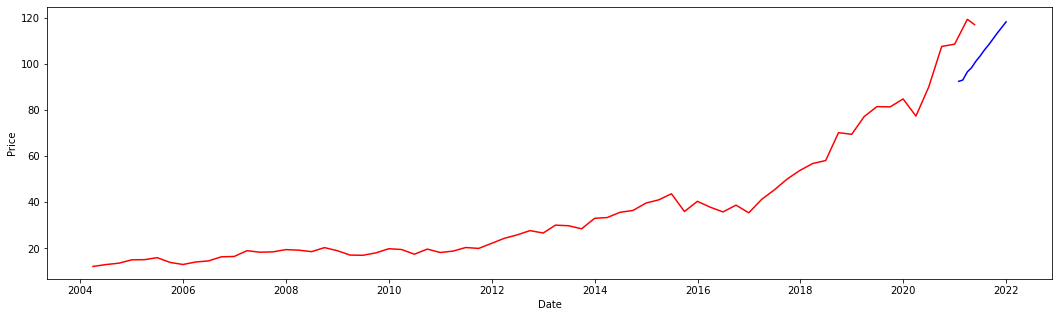



Forecasts (Dec 2020 - Feb 2021):	 [88.35, 91.25, 94.72]
Actual (Dec 2020 - Feb 2021):		 [119.34, 119.4, 120.08]
MAPE:					 23.55387256739835

End of Month Forecast for Dec 2021: $117.52369709739699


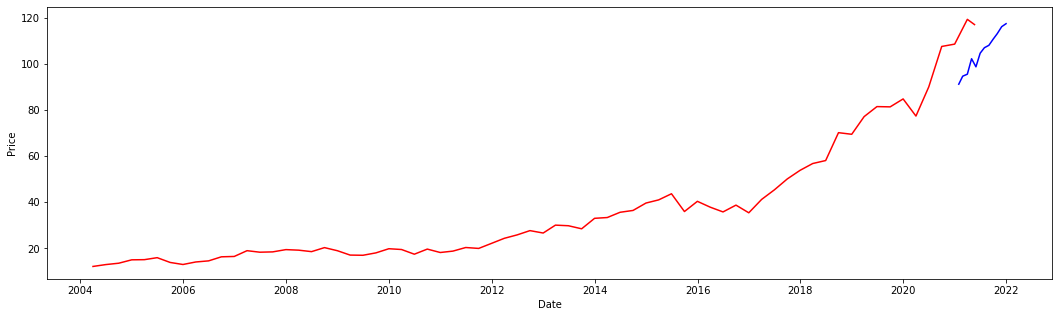



Forecasts (Dec 2020 - Feb 2021):	 [89.91, 91.62, 93.99]
Actual (Dec 2020 - Feb 2021):		 [119.34, 119.4, 120.08]
MAPE:					 23.219672915370428

End of Month Forecast for Dec 2021: $109.53389689168854


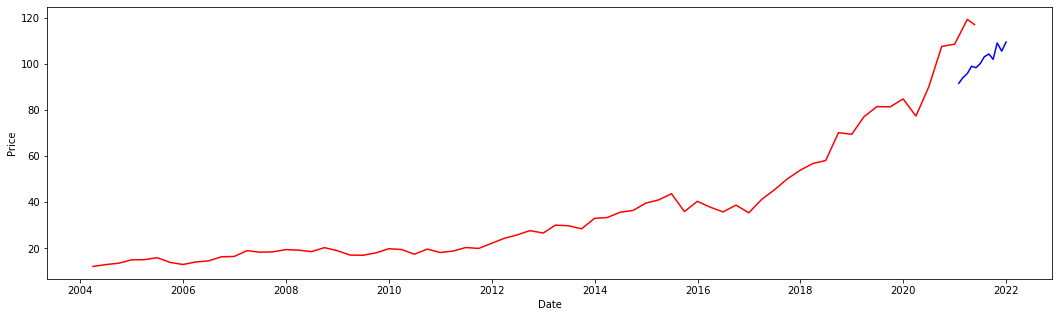



Forecasts (Dec 2020 - Feb 2021):	 [88.16, 88.28, 88.69]
Actual (Dec 2020 - Feb 2021):		 [119.34, 119.4, 120.08]
MAPE:					 26.111741831276603

End of Month Forecast for Dec 2021: $108.42612044978246


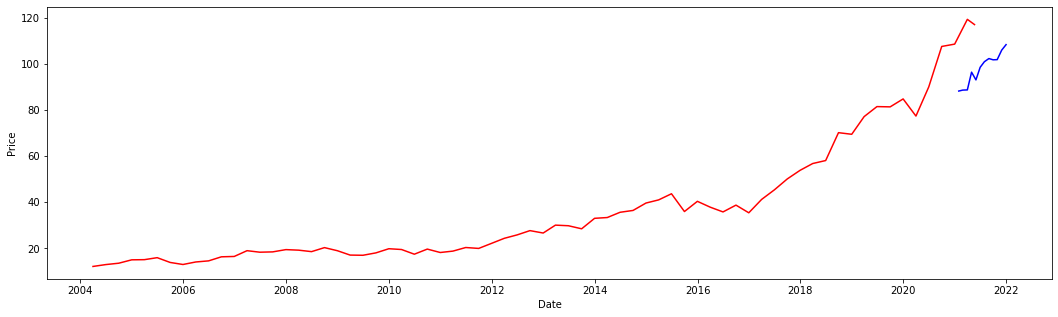

In [240]:
# Auto ARIMA
Quarterly(1,2,1)
print("\n")

# All others
Quarterly(6,2,6) # used
print("\n")
Quarterly(7,2,6)
print("\n")
Quarterly(8,2,10)
print("\n")